## K-Fold CV for Fourier Basis regression

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd

### Exploratory data analysis

In the following cell, you will load in the Jay St - MetroTech subway ride dataset, and look at the columns.

In [2]:
df_jay = pd.read_csv("subway-jay-st.csv")

In [3]:
df_jay.head()

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference
0,04/20/2022 04:00:00 AM,N103,"Jay St-MetroTech (A,C,F,R)",BK,"F,C,R,A",omny,4,0,40.692337,-73.985939,POINT (-73.9859390258789 40.69233703613281)
1,02/03/2022 09:00:00 PM,N103,"Jay St-MetroTech (A,C,F,R)",BK,"F,C,R,A",metrocard,286,7,40.692337,-73.985939,POINT (-73.9859390258789 40.69233703613281)
2,04/02/2022 04:00:00 PM,N103,"Jay St-MetroTech (A,C,F,R)",BK,"F,C,R,A",omny,511,23,40.692337,-73.985939,POINT (-73.9859390258789 40.69233703613281)
3,02/15/2022 12:00:00 PM,N103,"Jay St-MetroTech (A,C,F,R)",BK,"F,C,R,A",metrocard,715,30,40.692337,-73.985939,POINT (-73.9859390258789 40.69233703613281)
4,02/11/2022 08:00:00 PM,N103,"Jay St-MetroTech (A,C,F,R)",BK,"F,C,R,A",omny,281,11,40.692337,-73.985939,POINT (-73.9859390258789 40.69233703613281)


In [4]:
df_jay.describe()

,ridership,transfers,latitude,longitude
count,28346.000000,28346.000000,28346.000000,28346.000000
mean,402.249136,17.737459,40.692337,-73.985939
std,453.312408,15.489872,0.000000,0.000000
min,1.000000,0.000000,40.692337,-73.985939
25%,80.000000,5.000000,40.692337,-73.985939
50%,278.000000,15.000000,40.692337,-73.985939
75%,544.000000,26.000000,40.692337,-73.985939
max,2768.000000,91.000000,40.692337,-73.985939


In [5]:
df_jay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28346 entries, 0 to 28345
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transit_timestamp   28346 non-null  object 
 1   station_complex_id  28346 non-null  object 
 2   station_complex     28346 non-null  object 
 3   borough             28346 non-null  object 
 4   routes              28346 non-null  object 
 5   payment_method      28346 non-null  object 
 6   ridership           28346 non-null  int64  
 7   transfers           28346 non-null  int64  
 8   latitude            28346 non-null  float64
 9   longitude           28346 non-null  float64
 10  Georeference        28346 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 2.4+ MB


The MetroCard and OMNY riders are reported in separate rows, but you care only about the total. You use the `groupby` and `agg` functions in pandas to 

* `groupby` the timestamp (which is rounded down to the nearest hour, i.e. a result is reported every hour)
* and then `agg`regate the results, by summing the `ridership` column within the group

with the results stored in `df`. (You also do some manipulation of the result, so that it will have two columns with the specific names `transit_timestamp` and `ridership`.)

In [6]:
df = df_jay.groupby('transit_timestamp').agg({'ridership': ['sum']})
df.columns = df.columns.droplevel(1)
df.reset_index(inplace=True)

In [7]:
df.head()

,transit_timestamp,ridership
0,01/01/2023 01:00:00 AM,315
1,01/01/2023 01:00:00 PM,743
2,01/01/2023 02:00:00 AM,185
3,01/01/2023 02:00:00 PM,740
4,01/01/2023 03:00:00 AM,95


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14279 entries, 0 to 14278
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   transit_timestamp  14279 non-null  object
 1   ridership          14279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 223.2+ KB


You have a few more things to do before you use this data, though!

First, you notice that the `transit_timestamp` column is read as a string - so you convert it to pandas `datetime` format.

In [10]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

Finally, you will:

* add some time-related features to the data: `hour` (0-23), `month` (1-12), `dayofweek` (0-6), and `hourofweek` (1-168).
* and sort the data by the `transit_timestamp` column.

In [12]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# fill in code here. pandas makes this easy!
# (following the example of our exploratory data analysis on the Brooklyn Bridge dataset)

df['hour'] = df['transit_timestamp'].dt.hour
df['month'] = df['transit_timestamp'].dt.month
df['dayofweek'] = df['transit_timestamp'].dt.dayofweek

# code to compute the hour of week is provided for you
df['hourofweek'] = df['transit_timestamp'].dt.dayofweek * 24 + (df['transit_timestamp'].dt.hour + 1)

# also, sort the dataset by `transit_timestamp`: 
df = df.sort_values(by='transit_timestamp')


You look at the data and think you're in a good position to start modeling:

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-c_5ouoh6 because the default path (/tmp/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


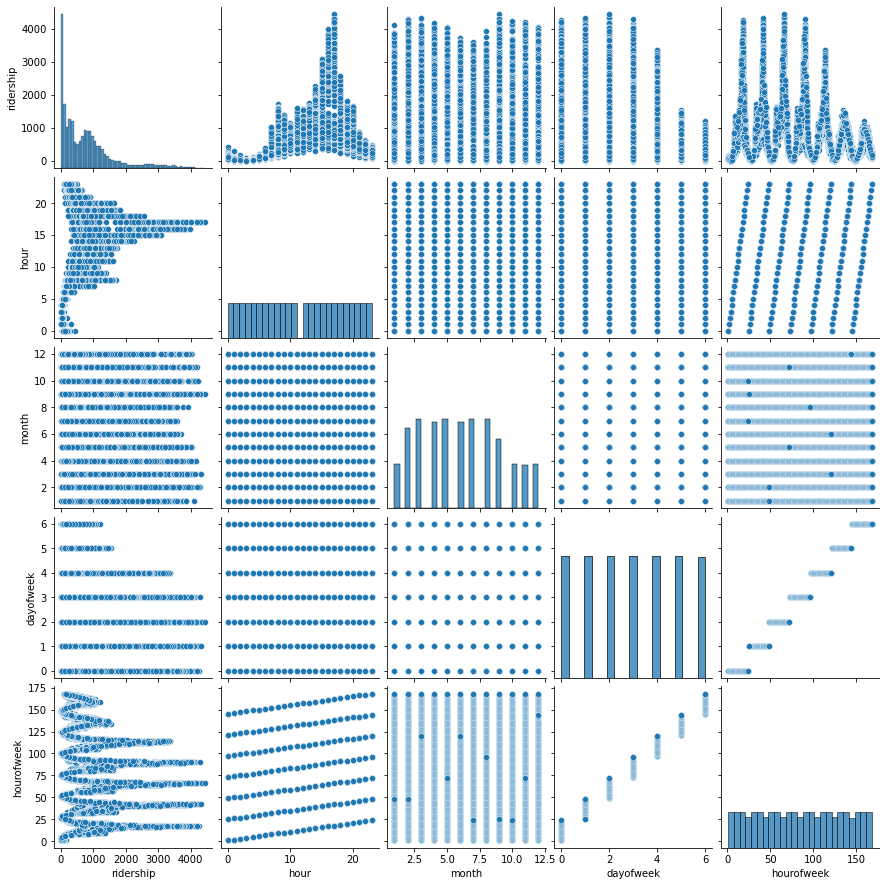

In [13]:
import seaborn as sns
sns.pairplot(df)

### Try a linear regression

You decide to first try a linear regression model trained directly on the features in the dataset. 

You define two DataFrames, `df_tr` and `df_ts`, with 10,000 samples in the training set and the rest assigned to the test set. Since this is time series data, you do *not* shuffle the data.

In the following cell, modify the call to `train_test_split`. Add arguments as follows:

* to specify the `train_size` (as 10,000 samples - specify the number of samples directly, not the fraction of the data) 
* and to specify whether or not to `shuffle`

In [14]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# modify this code - add arguments
df_tr, df_ts = train_test_split(df, train_size=10000, shuffle=False, random_state=42)

Then, you train a `LinearRegression` to predict `ridership` using the `hour`, `month`, `dayofweek`, and `hourofweek` features. Evaluate this regression model using the test data, and save the test R2 score in a variable named `r2_lr`.

Some notes:

* You can train and evaluate a model directly using a pandas DataFrame - you don't have to convert it to a numpy array first.
* The `fit` function expects the first argument to be either a pandas DataFrame or a 2D numpy array. When passing a pandas DataFrame, specify the first argument using a list of features as in `df[['x1','x2','x3']]` - note the double square brackets!
* The `fit` function expects the second argument to be either a pandas DataFrame OR Series, or a 2D OR 1D numpy array.  For example, you could pass `df['y']` (a DataFrame), `df['y']` (a Series), or `df['y'].values` (a 1D numpy array) - any of these would be acceptable.

In [15]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
lr = LinearRegression()
lr.fit(df_tr[['hour', 'month', 'dayofweek', 'hourofweek']], df_tr['ridership'])
predictions = lr.predict(df_ts[['hour', 'month', 'dayofweek', 'hourofweek']])
r2_lr = r2_score(df_ts['ridership'], predictions)

Unfortunately, this model doesn't do as well as you hoped. 

You noticed earlier (in the pairplot you created) that there is a highly periodic pattern in `hourofweek` with respect to ridership. You think you will get better results with a model that is capable of "learning" these patterns.

### Create features for Fourier basis transformation

You decide to use a linear regression model with Fourier basis transformation of the `hourofweek` feature:

$$\hat{y}=w_0 + w_1 x +  \sum_{t \in \text{tlist}} w_{t,c} \cos(2\pi x/t)+w_{t,s} \sin(2\pi x/t)$$

where each sine and cosine pair represents the periodic behavior over a particular time interval. 

For example, if `tlist = [0.5, 1]`, then your model would be:

$$\hat{y}=w_0 + w_1 x + w_{0.5,c} \cos(2\pi x/0.5)+w_{0.5,s} \sin(2\pi x/0.5) + w_{1,c} \cos(2\pi x/1)+w_{1,s} \sin(2\pi x/1)$$


However, you do not know in advance what values or how many values to include in `tlist`. You will use K-fold CV to optimize this value.

First, create an array `tlist` that holds the *largest* possible set of values of `t` you will consider in your K-fold CV.  (In other words: the "most complex" model will be the model with the entire `tlist`.)

This list should include values from 1 to 50 (inclusive of both), at intervals of 1.  There will be a total of 50 entries in this list.

In [16]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

tlist = np.arange(1, 51)

In your K-fold CV, you will consider regressions on the Fourier basis-transformed data with an increasing number of transformed features using this list (in order). For example, 

* in the first iteration of your K-fold CV, you will evaluate the regression for `tlist_eval = []`. 
* In the second iteration of your K-fold CV, you will evaluate the regression for `tlist_eval = [1]`.
* In the third iteration, you will evaluate the regression for `tlist_eval = [1, 2]`

and so on, until, in the final iteration, you will evaluate the regression for *all* the values in `tlist`.

To minimize the required computation, you will create a "transformed" version of the dataset *outside* of your K-fold CV loops. 

This "transformed" dataset should have 

* all `1` values in its 1st column, 
* the original `X` (the value of the `hourofweek` feature) in its 2nd column, 
* and then the Fourier basis features in subsequent columns, in order.  (For example, the 3rd column should be $\cos(2\pi x/1)$, the 4th column should be $\sin(2\pi x/1)$, the 5th column should be $\cos(2\pi x/2)$, the 6th column should be $\sin(2\pi x/2)$, and so on.)

In the following cell, compute `Xtr_trans` and `Xts_trans`.  (These should have 102 columns each.)

In [17]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# this code is provided for you to create `Xtr` and `Xts` as numpy arrays 
# just un-comment. Then use them to generate `Xtr_trans` and `Xts_trans`. 
Xtr = df_tr['hourofweek'].values
Xts = df_ts['hourofweek'].values
ytr = df_tr['ridership'].values
yts = df_ts['ridership'].values

Xtr_trans = np.column_stack((np.ones_like(Xtr), Xtr))
Xts_trans = np.column_stack((np.ones_like(Xts), Xts))

for t in tlist:
    Xtr_trans = np.column_stack((Xtr_trans, np.cos(2 * np.pi * Xtr / t), np.sin(2 * np.pi * Xtr / t)))
    Xts_trans = np.column_stack((Xts_trans, np.cos(2 * np.pi * Xts / t), np.sin(2 * np.pi * Xts / t)))


Now, you are ready to fit a K-fold CV! In your CV, you will fit and evaluate a `LinearRegression` model (using the `sklearn` implementation) on an increasing number of columns of the data, as described above - 

* in the first iteration of your K-fold CV, you will evaluate the regression for `tlist_eval = []`. 
* In the second iteration of your K-fold CV, you will evaluate the regression for `tlist_eval = [1]`.
* In the third iteration, you will evaluate the regression for `tlist_eval = [1, 2]`

and so on, until, in the final iteration, you will evaluate the regression for *all* the values in `tlist`.

(Of course, you won't re-compute the Fourier basis transformation inside the loop - you'll just select the appropriate rows and columns from `Xtr_trans` in each iteration.)

Use the `sklearn` implementation of `KFold`, with the following specifications:

* use 5 splits
* because of the temporal structure of this data, you will not shuffle it

Inside your K-fold CV, you will save the validation R2 for each candidate `LinearRegression` model in an array named `r2_val`, so that afterwards, you can compute the mean R2 across folds for each model.

In [18]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

nfold = 5

r2_val = np.zeros((len(tlist) + 1, nfold))  
kf = KFold(n_splits=nfold, shuffle=False)
for i in range(len(tlist) + 1):  

    col_end = 2 + 2*i  
    fold = 0  
    for train_index, val_index in kf.split(Xtr_trans):

        X_train, X_val = Xtr_trans[train_index, :col_end], Xtr_trans[val_index, :col_end]
        y_train, y_val = ytr[train_index], ytr[val_index]
        
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        
        y_pred = lr.predict(X_val)
        r2_val[i, fold] = r2_score(y_val, y_pred)
        fold += 1



### Identify and evaluate the best model according to one-SE rule

Using `r2_val`, you will find the best model according to the one-SE rule. 

First, compute `r2_mean` - the mean validation score across folds - and `r2_se` - the standard error of the validation score across folds. 

In [19]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

r2_mean = np.mean(r2_val, axis=1)
r2_se = np.std(r2_val, axis=1) / np.sqrt(nfold)

Finally, select the model with the best validation R2 using the one-SE rule. In `tlist_opt`, save the array of values of `t` for this model.

(For example: if the model with no Fourier basis features was the best, `tlist_opt` could be an empty list, `[]`. If the model with $\cos(2\pi x/1),  \sin(2\pi x/1), \cos(2\pi x/2),  \sin(2\pi x/2)$ was the best, `tlist_opt` would be `[1, 2]`.) 

In [20]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

best_model_index = np.argmax(r2_mean)
threshold = r2_mean[best_model_index] - r2_se[best_model_index]
for i in range(len(r2_mean)):
    if r2_mean[i] >= threshold:
        optimal_model_index = i
        break

tlist_opt = list(tlist[:optimal_model_index])
tlist_opt = np.array(tlist_opt)

Train a model on the entire training set for this `tlist_opt`, then evaluate its performance on the test set. Save the test R2 score in `r2_one_se`.

In [21]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
col_end = 2 + 2 * len(tlist_opt)  
Xtr_selected = Xtr_trans[:, :col_end]
Xts_selected = Xts_trans[:, :col_end]

lr_optimal = LinearRegression()
lr_optimal.fit(Xtr_selected, ytr)

yts_pred = lr_optimal.predict(Xts_selected)
r2_one_se = r2_score(yts, yts_pred)  